In [ ]:
!apt install libgraphviz-dev
!pip install -q pygraphviz
!pip install -q pomegranate

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 14 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

In [ ]:
from collections import defaultdict
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import pomegranate as pm
from scipy.stats import ttest_1samp



# Load datasheet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir data
!cp '/content/drive/My Drive/pred-analit/GC-Predictive-Analytics-worksheet - Sheet1 - week5.csv' data
df = pd.read_csv('data/GC-Predictive-Analytics-worksheet - Sheet1 - week5.csv')
df = df.drop([9, 10])
df = df.reset_index()
del df['cluster']
del df['Unnamed: 12']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘data’: File exists


In [ ]:
df

,index,Gender,Age,Ethnicity,Income,Work hours,Health condition,Education,Motivation,Attitude,Intention,Ownership,1,ER,2,ER.1,3,ER.2,4,ER.3,5,ER.4,6,ER.5,7,ER.6,8,ER.7,9,ER.8,10,ER.9,11,ER.10,12,ER.11,13,ER.12,14,ER.13,15,ER.14,16 Recommendation,Actual ER,17 Recommendation,Actual ER.1,18 Recommendation,Estimated ER
0,0,Female,44.0,Caucasian,"150,000-199,999",50+ hrs/week,Good,4-year college degree,0.265623,0.526590,0.507169,0.559363,Phy,0.166667,diet,0.714286,diet,0.428571,diet,0.571429,diet,0.750000,diet,0.428571,diet,0.857143,diet,1.0,diet,1.0,diet,0.285714,diet,0.571429,diet,0.500000,Phy,0.0,Phy,0.000000,Phy,0.000000,Phy,0,diet,0.0,NaN,NaN
1,1,Female,37.0,Asian,"100,000-149,999",16-35 hrs/week,Excellent,2-year college degree,0.386128,0.896973,0.736022,0.924759,diet,0.000000,diet,0.428571,diet,1.000000,diet,0.857143,diet,0.875000,diet,0.857143,diet,1.000000,diet,1.0,diet,1.0,diet,0.857143,diet,0.857143,diet,1.000000,diet,1.0,diet,0.857143,diet,0.428571,Phy,0,diet,0.0,NaN,NaN
2,2,Female,63.0,Caucasian,"0-24,999",50+ hrs/week,Excellent,2-year college degree,0.147511,0.593162,0.574159,0.928628,diet,0.000000,Phy,0.142857,Phy,0.000000,Phy,0.571429,Phy,0.000000,Phy,0.000000,Phy,0.000000,Phy,0.0,Phy,0.0,Phy,0.000000,Phy,0.000000,Phy,0.000000,diet,1.0,phy,1.000000,diet,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Female,37.0,African American,"0-24,999",1-15 hrs/week,Fair,"Some college, but no degree",0.492041,0.586625,0.645084,0.799052,Phy,0.000000,diet,0.000000,phy,0.000000,diet,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Female,62.0,African American,"50,000-99,999",1-15 hrs/week,Good,4-year college degree,0.594119,0.563496,0.659809,0.820454,diet,0.285714,diet,1.000000,Phy,0.470588,diet,0.900000,phy,0.916667,diet,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,Male,59.0,Caucasian,"50,000-99,999",36-50 hrs/week,Fair,4-year college degree,0.760602,0.541951,0.750184,0.664756,phy,0.058824,diet,0.500000,diet,0.500000,phy,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,Female,28.0,Asian,"50,000-99,999",50+ hrs/week,Good,4-year college degree,0.653543,0.731372,0.751441,0.976597,phy,0.250000,diet,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,Male,60.0,Asian,"150,000-199,999",50+ hrs/week,Good,Some graduate work,0.736708,0.675436,0.760342,0.974514,phy,0.166667,diet,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,Male,57.0,African American,"25,000-49,000",50+ hrs/week,Excellent,Some graduate work,0.550593,0.765072,0.800639,0.804968,diet,0.833333,Phy,0.857143,Phy,0.857143,Phy,1.000000,Phy,1.000000,Phy,0.714286,Phy,1.000000,Phy,1.0,Phy,1.0,Phy,1.000000,Phy,1.000000,Phy,0.833333,Phy,1.0,Phy,1.000000,Phy,1.000000,NaN,DROPPED,NaN,NaN,NaN,NaN
9,11,Male,40.0,HIspanic,"0-24,999",50+ hrs/week,Fair,4-year college degree,0.689156,0.647716,0.738081,0.975890,diet,0.000000,diet,0.000000,diet,0.285714,,0.000000,diet,0.125000,diet,0.428571,diet,0.000000,diet,0.0,diet,0.0,diet,0.000000,diet,0.000000,diet,0.000000,diet,0.0,diet,0.000000,diet,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


# Rearange data

In [ ]:
cat_fields = ['Gender', 'Ethnicity', 'Income', 'Work hours', 'Health condition', 'Education']
df[cat_fields] = df[cat_fields].apply(lambda col:pd.Categorical(col).codes).replace(-1,np.nan)

In [ ]:
df['Age'] = pd.qcut(df['Age'], 4, labels=False )

In [ ]:
cont_fields = ['Motivation', 'Attitude', 'Intention', 'Ownership']
pca = PCA().fit(df[cont_fields].fillna(0).to_numpy())
data = pca.transform(df[cont_fields].fillna(0).to_numpy())
df['Factor 1'] = pd.qcut(data[:, 0], 5, labels=False)
df['Factor 2'] = pd.qcut(data[:, 1], 5, labels=False)

del df['Motivation']
del df['Attitude']
del df['Intention']
del df['Ownership']

In [ ]:
rec_idxs = [str(i) for i in range(1, 15)]
er_idxs = ['ER']
er_idxs.extend(['ER.{}'.format(i) for i in range(1, 14)])
rec_idxs.append('16 Recommendation ')
rec_idxs.append('17 Recommendation')
er_idxs.append('Actual ER')
er_idxs.append('Actual ER.1')

In [ ]:
data = defaultdict(list)
fields = ['Gender', 'Age', 'Ethnicity', 'Income', 'Work hours', 'Health condition', 'Education', 'Factor 1', 'Factor 2']

for i in range(len(df)):
  for j in range(1, len(rec_idxs)):
      if df[er_idxs[j-1]][i] == 'DROPPED' or df[er_idxs[j]][i] == 'DROPPED':
        continue
      prev_er = float(df[er_idxs[j-1]][i])
      cur_rec = df[rec_idxs[j]][i]
      cur_er = float(df[er_idxs[j]][i])
      if pd.isna(cur_rec):
        continue

      if cur_rec == 'Phy':
        cur_rec = 0
      else:
        cur_rec = 1

      for field in fields:
        data[field].append(df[field][i])

      data['Previous er'].append(prev_er)
      data['Rec'].append(cur_rec)
      data['Er'].append(prev_er)

In [ ]:
df = pd.DataFrame(data=data)

,Gender,Age,Ethnicity,Income,Work hours,Health condition,Education,Factor 1,Factor 2,Previous er,Rec,Er
0,0,1,2,2.0,3.0,2.0,1.0,4,3,0.166667,1,0.166667
1,0,1,2,2.0,3.0,2.0,1.0,4,3,0.714286,1,0.714286
2,0,1,2,2.0,3.0,2.0,1.0,4,3,0.428571,1,0.428571
3,0,1,2,2.0,3.0,2.0,1.0,4,3,0.571429,1,0.571429
4,0,1,2,2.0,3.0,2.0,1.0,4,3,0.750000,1,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...
129,1,3,2,3.0,2.0,2.0,0.0,1,4,0.000000,1,0.000000
130,1,3,2,3.0,2.0,2.0,0.0,1,4,0.000000,1,0.000000
131,1,3,2,3.0,2.0,2.0,0.0,1,4,0.000000,1,0.000000
132,1,3,2,3.0,2.0,2.0,0.0,1,4,0.000000,1,0.000000


In [ ]:
model = pm.BayesianNetwork.from_samples(df, algorithm='exact-dp')

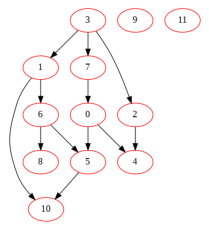

In [ ]:
model.plot()